# Subtask 1: Polarization Detection with deBERTa v3

## 1. Environment Setup

In [ ]:
!pip install -q transformers datasets accelerate evaluate
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00


In [2]:
import os
import gc
import json
import random
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed
)

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
class Config:
    MODEL_NAME = "microsoft/deberta-v3-base"
    NUM_LABELS = 2

    # Training configuration
    MAX_LENGTH = 384
    BATCH_SIZE = 16
    EVAL_BATCH_SIZE = 32
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 5
    WARMUP_RATIO = 0.06
    WEIGHT_DECAY = 0.01
    GRADIENT_ACCUMULATION_STEPS = 1

    VALIDATION_SPLIT = 0.1

    TEXT_COL = "text_en"
    LABEL_COL = "polarization"
    LANGUAGE_COL = "language"

    TRANSLATIONS_DIR = "./translations"
    OUTPUT_DATASET_PATH = "./english_dataset.csv"
    DEV_PATH = "./dev_english.csv"
    OUTPUT_DIR = "./output_subtask1_deberta_english"

    USE_CLASS_WEIGHTS = True

    SEED = 42

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()
set_seed(config.SEED)
print(f"Using device: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")

Using device: cuda
Model: microsoft/deberta-v3-base


## 2. Data Loading and Preprocessing

In [ ]:
# Data Loading
from google.colab import drive
drive.mount('/content/drive')

config.TRANSLATIONS_DIR = './drive/MyDrive/Colab_Data/translations/'
config.OUTPUT_DATASET_PATH = './drive/MyDrive/Colab_Data/output/english_dataset.csv'

Mounted at /content/drive


In [ ]:
# Data Preprocessing
def load_and_merge_translation_csvs(
    translations_dir: str,
    output_path: str,
    drop_cols: Optional[List[str]] = None
):
    translations_path = Path(translations_dir)
    if not translations_path.exists():
        raise FileNotFoundError(f"Translations directory not found: {translations_path.resolve()}")

    csv_files = sorted([p for p in translations_path.glob("*.csv")])
    if len(csv_files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {translations_path.resolve()}")

    frames = []
    for fp in tqdm(csv_files, desc="Loading translation CSVs"):
        df = pd.read_csv(fp)
        if drop_cols:
            for c in drop_cols:
                if c in df.columns:
                    df = df.drop(columns=[c])
 
        if config.LANGUAGE_COL not in df.columns:
            parts = fp.stem.split('_')
            lang_guess = parts[1] if len(parts) >= 2 else parts[0]
            lang_guess = 'en' if lang_guess == 'en' else lang_guess
            df[config.LANGUAGE_COL] = lang_guess
        frames.append(df)

    merged = pd.concat(frames, ignore_index=True)
    merged.to_csv(output_path, index=False)
    print(f"Saved merged dataset -> {output_path}")
    return merged


def load_or_build_english_dataset():
    """Load `english_dataset.csv` if present; otherwise build it from translation files."""
    out_path = Path(config.OUTPUT_DATASET_PATH)
    if out_path.exists():
        print(f"Loading existing merged dataset: {out_path.resolve()}")
        loaded = pd.read_csv(out_path)
        
        if config.LANGUAGE_COL in loaded.columns:
            nunq = loaded[config.LANGUAGE_COL].nunique(dropna=False)
            csv_count = len(list(Path(config.TRANSLATIONS_DIR).glob('*.csv')))
            if nunq <= 1 and csv_count >= 2:
                print(f"Detected only {nunq} unique value in '{config.LANGUAGE_COL}' in the cached merged dataset. Rebuilding it from translation CSVs...")
                return load_and_merge_translation_csvs(
                    translations_dir=config.TRANSLATIONS_DIR,
                    output_path=config.OUTPUT_DATASET_PATH,
                    drop_cols=['text']
                )
        return loaded

    print("Merged dataset not found. Building it from translation CSVs...")
    return load_and_merge_translation_csvs(
        translations_dir=config.TRANSLATIONS_DIR,
        output_path=config.OUTPUT_DATASET_PATH,
        drop_cols=['text']
    )


def standardize_for_training(df: pd.DataFrame):
    """Standardize column names for training: text + polarization."""
    if config.TEXT_COL not in df.columns:
        raise ValueError(f"Missing text column: {config.TEXT_COL}. Available: {list(df.columns)}")
    if config.LABEL_COL not in df.columns:
        raise ValueError(f"Missing label column: {config.LABEL_COL}. Available: {list(df.columns)}")

    out = df.copy()
    out = out.rename(columns={config.TEXT_COL: "text", config.LABEL_COL: "polarization"})
    out["text"] = out["text"].astype(str)
    out["polarization"] = out["polarization"].astype(int)
    return out

In [6]:
# Load (or build) the merged dataset
raw_df = load_or_build_english_dataset()
print(raw_df.shape)
raw_df.head()

Loading existing merged dataset: /content/drive/MyDrive/Colab_Data/output/english_dataset.csv
Detected only 1 unique value in 'language' in the cached merged dataset. Rebuilding it from translation CSVs...


Loading translation CSVs:   0%|          | 0/12 [00:00<?, ?it/s]

Saved merged dataset -> ./drive/MyDrive/Colab_Data/output/english_dataset.csv
(38444, 4)


,id,polarization,text_en,language
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,1,"Dreams of you, of me, of me, of you, until you...",arb
1,arb_6723e56a672674a6c1d9b28b213c4a05,1,"An old man's dream, a man's dream, a fantasy o...",arb
2,arb_b0365d606edeee38ae6c025b1ca33e96,1,The queen's peaches are dreams of the gay thin...,arb
3,arb_858c0ee684049ba6f416a6cecb0b0761,1,God disgraces the dreams of her and the hopele...,arb
4,arb_bdafc73afd0bc2cd2badae2a089446b9,1,"The mother of dreams shall be made unto her, a...",arb


In [7]:
# Standardize columns
df = standardize_for_training(raw_df)
print(df.shape)
df.head()

(38444, 4)


,id,polarization,text,language
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,1,"Dreams of you, of me, of me, of you, until you...",arb
1,arb_6723e56a672674a6c1d9b28b213c4a05,1,"An old man's dream, a man's dream, a fantasy o...",arb
2,arb_b0365d606edeee38ae6c025b1ca33e96,1,The queen's peaches are dreams of the gay thin...,arb
3,arb_858c0ee684049ba6f416a6cecb0b0761,1,God disgraces the dreams of her and the hopele...,arb
4,arb_bdafc73afd0bc2cd2badae2a089446b9,1,"The mother of dreams shall be made unto her, a...",arb


In [8]:
# Basic checks
print("Columns:", df.columns.tolist())
print("\nLabel distribution:")
print(df["polarization"].value_counts())

Columns: ['id', 'polarization', 'text', 'language']

Label distribution:
polarization
0    19669
1    18775
Name: count, dtype: int64


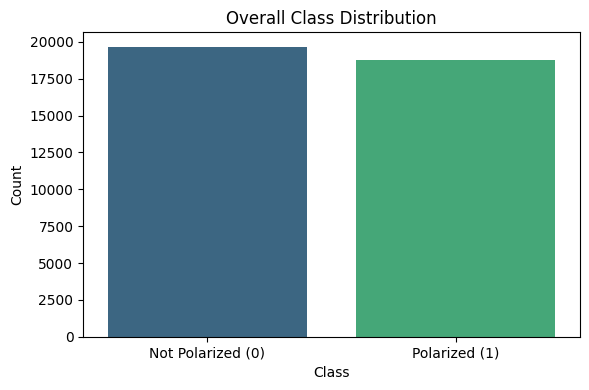

In [ ]:
# Class Distribution
plt.figure(figsize=(6, 4))

counts = df["polarization"].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values, palette='viridis')

plt.title("Overall Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Not Polarized (0)", "Polarized (1)"], rotation=0)
plt.tight_layout()
plt.savefig("plot_distribution_subtask_1.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Train/Validation split with stratification per language

combined_train_data = []
val_data_by_language = {}

data = df.copy()

if config.LANGUAGE_COL not in data.columns:
    print(f"Warning: '{config.LANGUAGE_COL}' column not found. Falling back to a global stratified split.")
    train_data, val_data = train_test_split(
        data,
        test_size=config.VALIDATION_SPLIT,
        random_state=config.SEED,
        stratify=data["polarization"]
    )
    combined_train_data.append(train_data)
    val_data_by_language["global"] = val_data
else:
    for lang in sorted(data[config.LANGUAGE_COL].astype(str).unique()):
        lang_df = data[data[config.LANGUAGE_COL].astype(str) == lang].copy()

        if lang_df.empty:
            continue

        label_counts = lang_df["polarization"].value_counts()

        can_stratify = (label_counts.shape[0] > 1) and (label_counts.min() >= 2)
        if can_stratify:
            lang_train, lang_val = train_test_split(
                lang_df,
                test_size=config.VALIDATION_SPLIT,
                random_state=config.SEED,
                stratify=lang_df["polarization"]
            )
        else:
            print(
                f"Warning: Cannot stratify for language '{lang}' "
                f"(label counts: {label_counts.to_dict()}). Using non-stratified split."
            )
            lang_train, lang_val = train_test_split(
                lang_df,
                test_size=config.VALIDATION_SPLIT,
                random_state=config.SEED
            )

        combined_train_data.append(lang_train)
        val_data_by_language[lang] = lang_val

train_data = pd.concat(combined_train_data, ignore_index=True)

val_data = pd.concat([v for v in val_data_by_language.values() if v is not None and not v.empty], ignore_index=True)

print("Train data shape:", train_data.shape)
print("Global validation data shape:", val_data.shape)

print("\nValidation data shapes per language:")
for lang, df_val in val_data_by_language.items():
    print(f"  {lang}: {df_val.shape}")

print("\nTrain label distribution:")
print(train_data["polarization"].value_counts(normalize=True))

print("\nGlobal validation label distribution:")
print(val_data["polarization"].value_counts(normalize=True))

print("\nValidation label distribution per language:")
for lang, df_val in val_data_by_language.items():
    if df_val is None or df_val.empty:
        print(f"  {lang}: empty")
    else:
        dist = df_val["polarization"].value_counts(normalize=True).to_dict()
        print(f"  {lang}: {dist}")

Train data shape: (34594, 4)
Global validation data shape: (3850, 4)

Validation data shapes per language:
  arb: (338, 4)
  ben: (334, 4)
  deu: (318, 4)
  en: (323, 4)
  hin: (275, 4)
  ita: (334, 4)
  pol: (240, 4)
  rus: (335, 4)
  spa: (331, 4)
  tur: (237, 4)
  urd: (357, 4)
  zho: (428, 4)

Train label distribution:
polarization
0    0.511621
1    0.488379
Name: proportion, dtype: float64

Global validation label distribution:
polarization
0    0.511688
1    0.488312
Name: proportion, dtype: float64

Validation label distribution per language:
  arb: {0: 0.5532544378698225, 1: 0.4467455621301775}
  ben: {0: 0.5718562874251497, 1: 0.4281437125748503}
  deu: {0: 0.5251572327044025, 1: 0.4748427672955975}
  en: {0: 0.6346749226006192, 1: 0.3653250773993808}
  hin: {1: 0.8545454545454545, 0: 0.14545454545454545}
  ita: {0: 0.5898203592814372, 1: 0.4101796407185629}
  pol: {0: 0.5791666666666667, 1: 0.42083333333333334}
  rus: {0: 0.6955223880597015, 1: 0.3044776119402985}
  spa: {1:

## 3. Dataset Class and Tokenization

In [ ]:
class PolarizationDataset(Dataset):
    """
    PyTorch Dataset for polarization classification.
    Handles tokenization and proper formatting for transformers.
    """

    def __init__(
        self,
        texts: List[str],
        labels: Optional[List[int]],
        tokenizer,
        max_length: int = 256
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None
        )

        item = {key: torch.tensor(val) for key, val in encoding.items()}

        if self.has_labels:
            item["labels"] = torch.tensor(int(self.labels[idx]))

        return item

In [ ]:
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

Loading tokenizer: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
# Create datasets
train_dataset = PolarizationDataset(
    texts=train_data["text"].tolist(),
    labels=train_data["polarization"].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_dataset = PolarizationDataset(
    texts=val_data["text"].tolist(),
    labels=val_data["polarization"].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_datasets = {}
for lang, df_val in val_data_by_language.items():
    if df_val is not None and not df_val.empty:
        val_datasets[lang] = PolarizationDataset(
            texts=df_val["text"].tolist(),
            labels=df_val["polarization"].tolist(),
            tokenizer=tokenizer,
            max_length=config.MAX_LENGTH
        )
    else:
        val_datasets[lang] = None

dev_dataset = None
dev_path = Path(config.DEV_PATH)
if dev_path.exists():
    dev_df = pd.read_csv(dev_path)
    # Expect a 'text_en' or 'text' column
    if config.TEXT_COL in dev_df.columns:
        dev_texts = dev_df[config.TEXT_COL].astype(str).tolist()
    elif "text" in dev_df.columns:
        dev_texts = dev_df["text"].astype(str).tolist()
    else:
        raise ValueError(f"Dev file found but missing text column. Columns: {dev_df.columns.tolist()}")

    dev_dataset = PolarizationDataset(
        texts=dev_texts,
        labels=None,
        tokenizer=tokenizer,
        max_length=config.MAX_LENGTH
    )
    print(f"Dev dataset size: {len(dev_dataset)}")
else:
    print("No dev file found (DEV_PATH). Skipping dev dataset.")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Global validation dataset size: {len(val_dataset)}")
print("Validation dataset sizes per language:")
for lang, dataset in val_datasets.items():
    if dataset:
        print(f"  {lang}: {len(dataset)}")
    else:
        print(f"  {lang}: Empty")

No dev file found (DEV_PATH). Skipping dev dataset.
Train dataset size: 34594
Global validation dataset size: 3850
Validation dataset sizes per language:
  arb: 338
  ben: 334
  deu: 318
  en: 323
  hin: 275
  ita: 334
  pol: 240
  rus: 335
  spa: 331
  tur: 237
  urd: 357
  zho: 428


## 4. Model Setup

In [ ]:
# Class Weights
if config.USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0, 1]),
        y=train_data["polarization"].values
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
    print(f"Class weights: {class_weights}")
else:
    class_weights = None

Class weights: tensor([0.9773, 1.0238], device='cuda:0')


In [ ]:
# Load Model
print(f"Loading model: {config.MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS
)
model.to(config.DEVICE)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading model: microsoft/deberta-v3-base


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. Training Setup

In [ ]:
# Training setup
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the Trainer.
    Primary metric: Macro F1 (as specified in the task)
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1_macro = f1_score(labels, predictions, average="macro")
    f1_weighted = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)

    f1_per_class = f1_score(labels, predictions, average=None)

    return {
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": precision,
        "recall_macro": recall,
        "accuracy": accuracy,
        "f1_class_0": f1_per_class[0],
        "f1_class_1": f1_per_class[1],
    }

In [17]:
class WeightedTrainer(Trainer):
    """
    Custom Trainer that supports class weights for imbalanced datasets.
    """

    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,

    num_train_epochs=config.NUM_EPOCHS,
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,

    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    logging_dir=os.path.join(config.OUTPUT_DIR, "logs"),
    logging_steps=50,
    report_to="none",
    save_total_limit=2,

    fp16=torch.cuda.is_available(),
)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

## 6. Training

In [ ]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting training...")
print("="*60)

# Train the model
train_result = trainer.train()

print("="*60)
print("Training completed!")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Starting training...


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Accuracy,F1 Class 0,F1 Class 1
1,0.557200,0.549863,0.714404,0.715058,0.721722,0.715245,0.717143,0.742370,0.686438
2,0.451200,0.569197,0.729928,0.730254,0.731194,0.729840,0.730649,0.743887,0.715968
3,0.334900,0.776452,0.728731,0.729034,0.729704,0.728632,0.729351,0.741696,0.715767
4,0.217500,1.038662,0.719297,0.719558,0.719776,0.719204,0.719740,0.730452,0.708142


Training completed!


In [ ]:
print("\nTraining Metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"  Final training loss: {train_result.metrics['train_loss']:.4f}")


Training Metrics:
  Total training time: 858.09s
  Samples/second: 201.57
  Final training loss: 0.3943


In [ ]:
print("\nValidation Evaluation:")
eval_metrics = trainer.evaluate()
print(eval_metrics)


Validation Evaluation:


{'eval_loss': 0.5691969394683838, 'eval_f1_macro': 0.7299278037413366, 'eval_f1_weighted': 0.7302541314886796, 'eval_precision_macro': 0.7311939268461007, 'eval_recall_macro': 0.7298398855167945, 'eval_accuracy': 0.7306493506493507, 'eval_f1_class_0': 0.7438873795999013, 'eval_f1_class_1': 0.7159682278827718, 'eval_runtime': 5.4966, 'eval_samples_per_second': 700.434, 'eval_steps_per_second': 22.014, 'epoch': 4.0}


## 7. Save Model

In [ ]:
trainer.save_model(config.OUTPUT_DIR)
tokenizer.save_pretrained(config.OUTPUT_DIR)

print(f"Saved model to: {config.OUTPUT_DIR}")

Saved model to: ./output_subtask1_deberta_english


## 8. Inference on Dev Set

In [ ]:
# Per-language results on the Validation splits

all_predictions_by_split = {}

if dev_dataset is not None:
    print("\n--- Running Inference on Dev Set ---")
    dev_preds = trainer.predict(dev_dataset)
    dev_pred_labels = np.argmax(dev_preds.predictions, axis=1)
    all_predictions_by_split["dev"] = {
        "pred_labels": dev_pred_labels,
        "original_df": dev_df
    }
    print(f"Predictions computed for Dev Set ({len(dev_pred_labels)} samples)")

for lang, dataset in val_datasets.items():
    if dataset is None:
        print(f"\n--- Skipping Inference for Language: {lang} (Empty dataset) ---")
        continue

    print(f"\n--- Running Inference on Validation Set for Language: {lang} ---")
    preds = trainer.predict(dataset)
    pred_labels = np.argmax(preds.predictions, axis=1)

    all_predictions_by_split[lang] = {
        "pred_labels": pred_labels,
        "original_df": val_data_by_language[lang]
    }
    print(f"Predictions computed for {lang} ({len(pred_labels)} samples)")

metric_rows = []
for name, data_dict in all_predictions_by_split.items():
    if name == "dev":
        continue

    y_true = data_dict["original_df"]["polarization"].values
    y_pred = data_dict["pred_labels"]

    precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)

    metric_rows.append({
        "language": name,
        "n_samples": len(y_true),
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
    })

metrics_by_language = (
    pd.DataFrame(metric_rows)
      .sort_values(["language"])
      .reset_index(drop=True)
)

print("\n==================== Per-language validation metrics ====================")
if len(metrics_by_language) == 0:
    print("No per-language validation results available (all language splits were empty).")
else:
    for _, r in metrics_by_language.iterrows():
        print(f"\nLanguage: {r['language']}  (n={int(r['n_samples'])})")
        print(f"  Accuracy        : {r['accuracy']:.4f}")
        print(f"  Precision (macro): {r['precision_macro']:.4f}")
        print(f"  Recall (macro)   : {r['recall_macro']:.4f}")
        print(f"  F1 (macro)       : {r['f1_macro']:.4f}")

    mean_metrics = metrics_by_language[["accuracy", "precision_macro", "recall_macro", "f1_macro"]].mean()

    print("\n==================== Aggregated (mean over languages) ====================")
    if len(metrics_by_language) != 12:
        print(f"NOTE: computed mean over {len(metrics_by_language)} languages (expected 12).")
    print(f"Accuracy        : {mean_metrics['accuracy']:.4f}")
    print(f"Precision (macro): {mean_metrics['precision_macro']:.4f}")
    print(f"Recall (macro)   : {mean_metrics['recall_macro']:.4f}")
    print(f"F1 (macro)       : {mean_metrics['f1_macro']:.4f}")

    display(
        metrics_by_language[["language", "n_samples", "accuracy", "precision_macro", "recall_macro", "f1_macro"]]
          .style.format({
              "accuracy": "{:.4f}",
              "precision_macro": "{:.4f}",
              "recall_macro": "{:.4f}",
              "f1_macro": "{:.4f}",
          })
    )

os.makedirs(config.OUTPUT_DIR, exist_ok=True)
metrics_path = os.path.join(config.OUTPUT_DIR, "metrics_by_language_val.csv")
metrics_by_language.to_csv(metrics_path, index=False)
print(f"\nSaved per-language validation metrics -> {metrics_path}")

for name, data_dict in all_predictions_by_split.items():
    pred_labels = data_dict["pred_labels"]
    original_df = data_dict["original_df"]

    out_path = os.path.join(config.OUTPUT_DIR, f"predictions_{name}.csv")
    if name == "dev":
        out_df = pd.DataFrame({"prediction": pred_labels})
    else:
        out_df = original_df.reset_index(drop=True).copy()
        out_df["prediction"] = pred_labels

    out_df.to_csv(out_path, index=False)
    print(f"Saved predictions -> {out_path}")


--- Running Inference on Validation Set for Language: arb ---


Predictions computed for arb (338 samples)

--- Running Inference on Validation Set for Language: ben ---


Predictions computed for ben (334 samples)

--- Running Inference on Validation Set for Language: deu ---


Predictions computed for deu (318 samples)

--- Running Inference on Validation Set for Language: en ---


Predictions computed for en (323 samples)

--- Running Inference on Validation Set for Language: hin ---


Predictions computed for hin (275 samples)

--- Running Inference on Validation Set for Language: ita ---


Predictions computed for ita (334 samples)

--- Running Inference on Validation Set for Language: pol ---


Predictions computed for pol (240 samples)

--- Running Inference on Validation Set for Language: rus ---


Predictions computed for rus (335 samples)

--- Running Inference on Validation Set for Language: spa ---


Predictions computed for spa (331 samples)

--- Running Inference on Validation Set for Language: tur ---


Predictions computed for tur (237 samples)

--- Running Inference on Validation Set for Language: urd ---


Predictions computed for urd (357 samples)

--- Running Inference on Validation Set for Language: zho ---


Predictions computed for zho (428 samples)

==================== Per-language validation metrics ====================

Language: arb  (n=338)
  Accuracy        : 0.7663
  Precision (macro): 0.7654
  Recall (macro)   : 0.7594
  F1 (macro)       : 0.7613

Language: ben  (n=334)
  Accuracy        : 0.7455
  Precision (macro): 0.7436
  Recall (macro)   : 0.7485
  F1 (macro)       : 0.7436

Language: deu  (n=318)
  Accuracy        : 0.6730
  Precision (macro): 0.6808
  Recall (macro)   : 0.6661
  F1 (macro)       : 0.6632

Language: en  (n=323)
  Accuracy        : 0.8111
  Precision (macro): 0.7998
  Recall (macro)   : 0.7865
  F1 (macro)       : 0.7920

Language: hin  (n=275)
  Accuracy        : 0.7673
  Precision (macro): 0.6359
  Recall (macro)   : 0.7186
  F1 (macro)       : 0.6504

Language: ita  (n=334)
  Accuracy        : 0.6018
  Precision (macro): 0.6013
  Recall (macro)   : 0.6046
  F1 (macro)       : 0.5983

Language: pol  (n=240)
  Accuracy        : 0.7625
  Precision (macro): 0

,language,n_samples,accuracy,precision_macro,recall_macro,f1_macro
0,arb,338,0.7663,0.7654,0.7594,0.7613
1,ben,334,0.7455,0.7436,0.7485,0.7436
2,deu,318,0.6730,0.6808,0.6661,0.6632
3,en,323,0.8111,0.7998,0.7865,0.7920
4,hin,275,0.7673,0.6359,0.7186,0.6504
5,ita,334,0.6018,0.6013,0.6046,0.5983
6,pol,240,0.7625,0.7599,0.7476,0.7513
7,rus,335,0.7940,0.7587,0.7417,0.7489
8,spa,331,0.7160,0.7168,0.7161,0.7158
9,tur,237,0.6751,0.6762,0.6740,0.6736



Saved per-language validation metrics -> ./output_subtask1_deberta_english/metrics_by_language_val.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_arb.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_ben.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_deu.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_en.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_hin.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_ita.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_pol.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_rus.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_spa.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_tur.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_urd.csv
Saved predictions -> ./output_subtask1_deberta_english/predictions_zho.c

## 9. Load Saved Model (for later use)

In [ ]:
loaded_tokenizer = AutoTokenizer.from_pretrained(config.OUTPUT_DIR)
loaded_model = AutoModelForSequenceClassification.from_pretrained(config.OUTPUT_DIR)
loaded_model.to(config.DEVICE)

print("Loaded model + tokenizer from:", config.OUTPUT_DIR)

The tokenizer you are loading from './output_subtask1_deberta_english' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded model + tokenizer from: ./output_subtask1_deberta_english
